In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    MDS,
    TSNE,
    Isomap,
    LocallyLinearEmbedding,
    SpectralEmbedding,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection
import plotly.express as px

print(sns.__version__)
# Save a palette to a variable:
palette = sns.color_palette("bright")

sns.set_palette(palette)
sns.set(style="whitegrid", font_scale=2.5)

seed = 1823492

0.12.2


# corona

<div class="alert alert-block alert-info">
<h2> Clustering of outliers </h2>
</div>

In [2]:
CORONA_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/corona/similarity_matrix/"
INTERIM_PATH = "/m/cs/work/luongn1/digirhythm/data/interim/corona/"
PROCESSED_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/corona/"

study = "corona"
with open(f"../config/features.txt") as f:
    features = json.load(f)

freq = "4epochs"
FEATURES = features[study][freq]

similarity_baseline_si = pd.read_csv(
    CORONA_PATH + f"si/similarity_baseline_{freq}.csv", index_col=0
)

similarity_baseline_si.index = similarity_baseline_si.index.astype("str")

# All behaviour
behaviour_df = pd.read_csv(
    PROCESSED_PATH + f"{study}_all_features_{freq}.csv", index_col=0
)

# Baseline behaviour
baseline_df = pd.read_csv(
    INTERIM_PATH + f"all_participants/{freq}_si_baseline.csv", index_col=0
)

# Survey
survey_df = pd.read_csv(INTERIM_PATH + f"survey_all.csv")
survey_df.date = pd.to_datetime(survey_df.date)
survey_df["month"] = survey_df.date.dt.month - 1  # Align with past mon

# Define bins for low, medium, and high stress
bins = [0, 10, 23, 37]  # Adjust these bins according to your data and needs
labels = ["low", "medium", "high"]

# Categorize the 'PSS10' scores
survey_df["Stress level"] = pd.cut(
    survey_df["PSS"], bins=bins, labels=labels, include_lowest=True
)

behaviour_df

big5 = [col for col in survey_df.columns if col.startswith("BIG5")]

survey_df[big5] = survey_df.groupby("subject_id")[big5].fillna(method="ffill")
survey_df

,subject_id,time time,DayOnLeave,How many days in December did you spend in in-person work-related events (such as research visits; sabbatical; conferences; etc) outside of Aalto campus (either in Finland or abroad)?,PercTimeSpentOnsite,CovidDoses,In December how many days did you spend outside of Finland?,In December how many days did you spend traveling within Finland (being outside of the region(s) were you typically live and work)?,In the past two months how often have you looked at your data on the Polar app?,PSQI_Disturbance,...,PANAS_POS_Pre,BIG5_Extraversion,BIG5_Agreeableness,BIG5_Conscientiousness,BIG5_Neuroticism,BIG5_Openness,MEQ,UCLA3,month,Stress level
0,1015720192,2021-06-22 06:36:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,14,12.0,13.0,13.0,10.0,15.0,14,0,5,medium
1,1015720192,2021-08-10 08:32:06,18.0,NaN,0.0,2,NaN,NaN,NaN,1,...,0,12.0,13.0,13.0,10.0,15.0,0,0,7,medium
2,1015720192,2021-09-13 06:00:19,1.0,NaN,1.0,2,NaN,NaN,NaN,2,...,0,12.0,13.0,13.0,10.0,15.0,0,0,8,medium
3,1015720192,2021-10-18 06:18:19,0.0,NaN,5.0,2,NaN,NaN,NaN,1,...,0,12.0,13.0,13.0,10.0,15.0,0,0,9,medium
4,1015720192,2021-11-17 12:54:57,1.0,NaN,40.0,2,NaN,NaN,at-least-once-a-day,1,...,0,12.0,13.0,13.0,10.0,15.0,0,0,10,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,976450812,2022-06-20 12:53:45,1.0,NaN,30.0,NaN,NaN,NaN,NaN,1,...,8,9.0,9.0,7.0,12.0,15.0,0,8,5,medium
1238,994459560,2021-06-30 09:40:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,13,5.0,12.0,12.0,7.0,8.0,13,0,5,medium
1239,994459560,2021-09-17 14:05:21,3.0,NaN,0.0,2,NaN,NaN,NaN,1,...,0,5.0,12.0,12.0,7.0,8.0,0,0,8,medium
1240,994459560,2021-10-17 16:18:02,0.0,NaN,0.0,2,NaN,NaN,NaN,2,...,0,5.0,12.0,12.0,7.0,8.0,0,0,9,medium


In [3]:
# Outliers - Days deviating the most from baseline
thres = 1.85


def outliers(similarity, thres):
    # Calculate mean and standard deviation
    mean = similarity.mean()
    std_dev = similarity.std()

    # Calculate the lower threshold
    lower_threshold = mean - thres * std_dev

    # Find indexes of outliers
    outliers = similarity[similarity <= lower_threshold].index

    return outliers


behaviour_df

,index_x,subject_id,date,heart_rate_avg,beat_to_beat_avg,heart_rate_variability_avg,breathing_rate_avg,nightly_recharge_status,ans_charge,ans_charge_status,...,stepsx1000:total:norm,steps:total:norm,index_y,tst,midsleep,bedtime,waketime,total_interruption_duration,tst:norm,midsleep:norm
0,82,2123461352,2021-06-22,56,1056,39.0,15.2,1.0,-2.6,NaN,...,0.125396,0.125396,61,6.50,27.23,23.98,30.66,660,0.344045,0.533632
1,83,3671581472,2021-06-23,63,949,43.0,13.8,5.0,1.6,NaN,...,0.355529,0.355529,83,6.86,28.01,24.58,32.34,3240,0.624031,0.308357
2,84,3609986162,2021-06-23,52,1145,98.0,10.8,5.0,8.0,NaN,...,0.505332,0.505332,84,6.76,25.72,22.34,29.58,1710,0.502868,0.496760
3,85,2123461352,2021-06-23,55,1079,61.0,15.6,5.0,1.1,NaN,...,0.077122,0.077122,85,7.93,26.50,22.54,30.64,630,0.614367,0.206278
4,86,3671581472,2021-06-24,60,994,43.0,13.2,5.0,6.3,NaN,...,0.524269,0.524269,86,6.07,28.58,25.55,32.42,2880,0.470930,0.390490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27162,30362,943412086,2022-07-04,75,800,41.0,13.2,3.0,-3.7,2.0,...,0.713109,0.713109,18257,8.46,27.68,23.45,32.60,2490,0.572581,0.746622
27163,30363,91109228,2022-07-04,57,1046,57.0,14.6,1.0,-7.0,1.0,...,0.207454,0.207454,18258,6.39,28.28,25.09,32.25,2760,0.414673,0.335832
27164,30364,2038129448,2022-07-04,52,1150,76.0,12.9,6.0,10.0,5.0,...,0.307895,0.307895,18259,8.29,29.76,25.61,34.42,1860,0.596330,0.523026
27165,30365,894567464,2022-07-03,58,1034,52.0,14.3,2.0,-6.5,1.0,...,0.522049,0.522049,18260,7.34,28.39,24.72,32.63,2040,0.646077,0.675532


In [4]:
# Convert to vector of difference from the means

mean_diff = pd.DataFrame()
outliers_behav_df = pd.DataFrame()
sample_survey = survey_df[
    [
        "subject_id",
        "age",
        "gender",
        "occupation",
        "origin",
        "PSS",
        "Stress level",
        "PHQ",
        "PSQI",
        "month",
        "BIG5_Extraversion",
        "BIG5_Agreeableness",
        "BIG5_Conscientiousness",
        "BIG5_Neuroticism",
        "BIG5_Openness",
    ]
]
sample_survey.subject_id = sample_survey.subject_id.astype(int)

for uid in similarity_baseline_si.index.unique():
    s_si = similarity_baseline_si.loc[uid].dropna()
    outliers_indices = outliers(s_si, thres)

    outliers_behav = (
        behaviour_df[behaviour_df.subject_id == int(uid)]
        .reset_index()
        .iloc[outliers_indices]
    )
    outliers_behav.date = pd.to_datetime(outliers_behav.date)
    sample_baseline = baseline_df[baseline_df.index == int(uid)]
    month = outliers_behav.date.dt.month

    diff_df = outliers_behav[FEATURES] - sample_baseline[FEATURES].values
    diff_df["subject_id"] = int(uid)
    diff_df["month"] = month
    diff_df = diff_df.merge(sample_survey, on=["subject_id", "month"], how="left")

    mean_diff = pd.concat([mean_diff, diff_df])
    outliers_behav_df = pd.concat([outliers_behav_df, outliers_behav])

mean_diff.dropna(subset=FEATURES, inplace=True)
mean_diff

/share/apps/anaconda-ci/fgci-centos7-generic/software/anaconda/2020-03-tf1/f43b17a3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,heart_rate_variability_avg:norm,stepsx1000:total:norm,steps:night:norm,steps:morning:norm,steps:afternoon:norm,steps:evening:norm,tst:norm,midsleep:norm,subject_id,month,...,origin,PSS,Stress level,PHQ,PSQI,BIG5_Extraversion,BIG5_Agreeableness,BIG5_Conscientiousness,BIG5_Neuroticism,BIG5_Openness
0,0.083090,-0.104097,0.000117,-0.386300,-0.297658,0.683841,0.013233,-0.204997,2123461352,8,...,0.0,10.0,low,0.0,5.0,6.0,13.0,11.0,6.0,14.0
1,-0.059767,-0.107805,-0.000006,-0.352281,-0.328851,0.681137,-0.024575,-0.196028,2123461352,8,...,0.0,10.0,low,0.0,5.0,6.0,13.0,11.0,6.0,14.0
2,0.062682,-0.088901,-0.000006,-0.395249,-0.328145,0.723399,0.018904,-0.182575,2123461352,9,...,0.0,12.0,medium,2.0,4.0,6.0,13.0,11.0,6.0,14.0
3,0.297376,-0.081949,-0.000006,-0.408543,-0.303955,0.712503,-0.041588,-0.182575,2123461352,9,...,0.0,12.0,medium,2.0,4.0,6.0,13.0,11.0,6.0,14.0
4,0.205539,-0.100622,-0.000006,-0.367970,-0.324292,0.692268,-0.011342,-0.128764,2123461352,9,...,0.0,12.0,medium,2.0,4.0,6.0,13.0,11.0,6.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,0.073593,-0.072610,-0.002457,0.848629,-0.282007,-0.564165,0.006835,-0.050760,91109228,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.043290,-0.163720,-0.005174,0.767048,-0.244351,-0.517523,-0.548189,0.255087,91109228,3,...,0.0,14.0,medium,2.0,6.0,13.0,15.0,7.0,6.0,8.0
4,0.088745,-0.266367,0.448911,0.494279,-0.369984,-0.573207,0.136022,-0.148212,91109228,4,...,0.0,11.0,medium,1.0,3.0,13.0,15.0,7.0,6.0,8.0
0,-0.094156,0.156980,-0.027500,-0.200323,-0.277536,0.505358,-0.109890,0.036152,3426284644,2,...,0.0,18.0,medium,1.0,10.0,9.0,12.0,11.0,10.0,12.0


In [5]:
from sklearn.metrics import silhouette_score

# Determine optimal cluster number with elbow method
wcss = []

silhouette_scores = []
for i in range(2, 11):
    model = KMeans(
        n_clusters=i,
        init="k-means++",  # Initialization method for kmeans
        max_iter=300,  # Maximum number of iterations
        n_init=10,  # Choose how often algorithm will run with different centroid
        random_state=0,
    )  # Choose random state for reproducibility
    labels = model.fit_predict(mean_diff[FEATURES])

    # Silhouette Index
    silhouette_avg = silhouette_score(mean_diff[FEATURES], labels)
    silhouette_scores.append(silhouette_avg)

# Determine optimal cluster number using maximum Silhouette score and maximum Dunn index
optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2
print("Optimal num cluster: ", optimal_clusters_silhouette)

Optimal num cluster:  6


In [6]:
kmeans = KMeans(
    n_clusters=optimal_clusters_silhouette,  # Set amount of clusters
    init="k-means++",  # Initialization method for kmeans
    max_iter=300,  # Maximum number of iterations
    n_init=10,  # Choose how often algorithm will run with different centroid
    random_state=seed,
)  # Choose random state for reproducibility

pred_y = kmeans.fit_predict(mean_diff[FEATURES])

mean_diff["cluster"] = kmeans.labels_ + 1
mean_diff.groupby("cluster").median()

,heart_rate_variability_avg:norm,stepsx1000:total:norm,steps:night:norm,steps:morning:norm,steps:afternoon:norm,steps:evening:norm,tst:norm,midsleep:norm,subject_id,month,...,occupation,origin,PSS,PHQ,PSQI,BIG5_Extraversion,BIG5_Agreeableness,BIG5_Conscientiousness,BIG5_Neuroticism,BIG5_Openness
cluster,,,,,,,,,,,,,,,,,,,,,
1,0.617143,0.029021,-0.001820,-0.027557,-0.000359,-0.001591,0.030823,0.046280,2.089631e+09,7.0,...,0.0,0.0,11.0,0.0,4.0,8.0,13.0,12.0,9.0,12.0
2,-0.030159,0.058461,-0.001931,-0.019055,0.088636,-0.133631,0.050038,0.007109,2.336730e+09,6.0,...,0.0,0.0,12.5,1.0,5.0,10.0,11.0,10.5,9.0,12.0
3,-0.111013,-0.279107,0.888376,-0.171163,-0.452804,-0.203408,-0.074008,0.133475,3.027628e+09,6.5,...,0.5,0.0,13.0,1.0,5.5,10.0,12.0,11.0,11.0,11.0
4,-0.169231,0.045003,0.071377,-0.144290,0.040158,-0.062509,-0.298319,0.560566,1.299735e+09,7.0,...,1.0,0.0,11.0,0.0,4.0,10.0,11.0,12.0,8.0,12.0
5,0.034921,-0.049000,-0.000316,-0.179829,-0.328756,0.523497,0.004172,0.074302,2.145463e+09,6.5,...,0.0,0.0,12.0,1.0,4.0,10.0,12.0,11.0,8.0,12.0
6,-0.023980,-0.268699,0.000460,0.665834,-0.389633,-0.299931,0.010531,-0.034585,2.149651e+09,7.0,...,0.0,0.0,12.0,1.0,4.0,10.0,12.0,12.0,8.0,12.0


In [7]:
import numpy as np
from matplotlib import offsetbox

from sklearn.preprocessing import MinMaxScaler


# PCA on meandiff

X = mean_diff[FEATURES].values
y = mean_diff["cluster"]


n_neighbors = 10
n_components = 3
embeddings = {
    "Isomap": Isomap(n_neighbors=n_neighbors, n_components=n_components),
    "MDS": MDS(n_components=n_components, n_init=1, max_iter=120, n_jobs=2),
    "Random Trees": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=n_components),
    ),
    "Spectral": SpectralEmbedding(
        n_components=n_components, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE": TSNE(
        n_components=n_components,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
}

colors = ["#fc8d59", "#d73027", "#2e88df", "#762a81", "#99d594", "#3288bd"]
palette = sns.color_palette(colors, as_cmap=True)


from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X.copy()
        data.flat[:: X.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y)
    timing[name] = time() - start_time

Computing Isomap...
Computing MDS...
Computing Random Trees...
Computing Spectral...
Computing t-SNE...


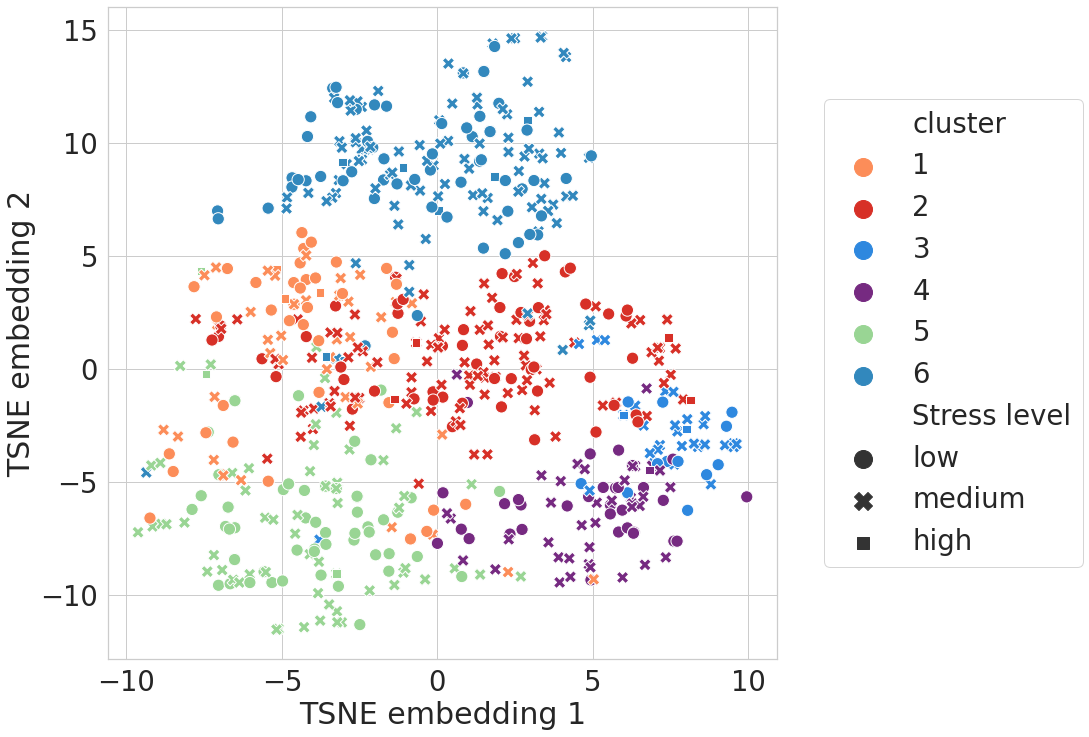

In [8]:
def plot_embedding(X, title):
    fig = plt.figure(figsize=(12, 12))
    g = sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        style=mean_diff["Stress level"],
        hue=mean_diff["cluster"],
        palette=palette,
        s=150,
    )
    #    fig = px.scatter_3d(X, x=X[:, 0], y=X[:, 1], z=X[:, 2], color = mean_diff["cluster"], width=1000, height=1000,
    #                       color_discrete_sequence=px.colors.qualitative.Set2)
    g.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), ncol=1, markerscale=3)
    g.set_xlabel("TSNE embedding 1")
    g.set_ylabel("TSNE embedding 2")
    return g


# px.scatter_3d(X, x=X[:, 0], y=X[:, 1], z=X[:, 2], color = mean_diff["cluster"])
fig = plot_embedding(projections["t-SNE"], "TSNE")
plt.savefig("tsne_embedding.png", dpi=300, bbox_inches="tight")
plt.show()

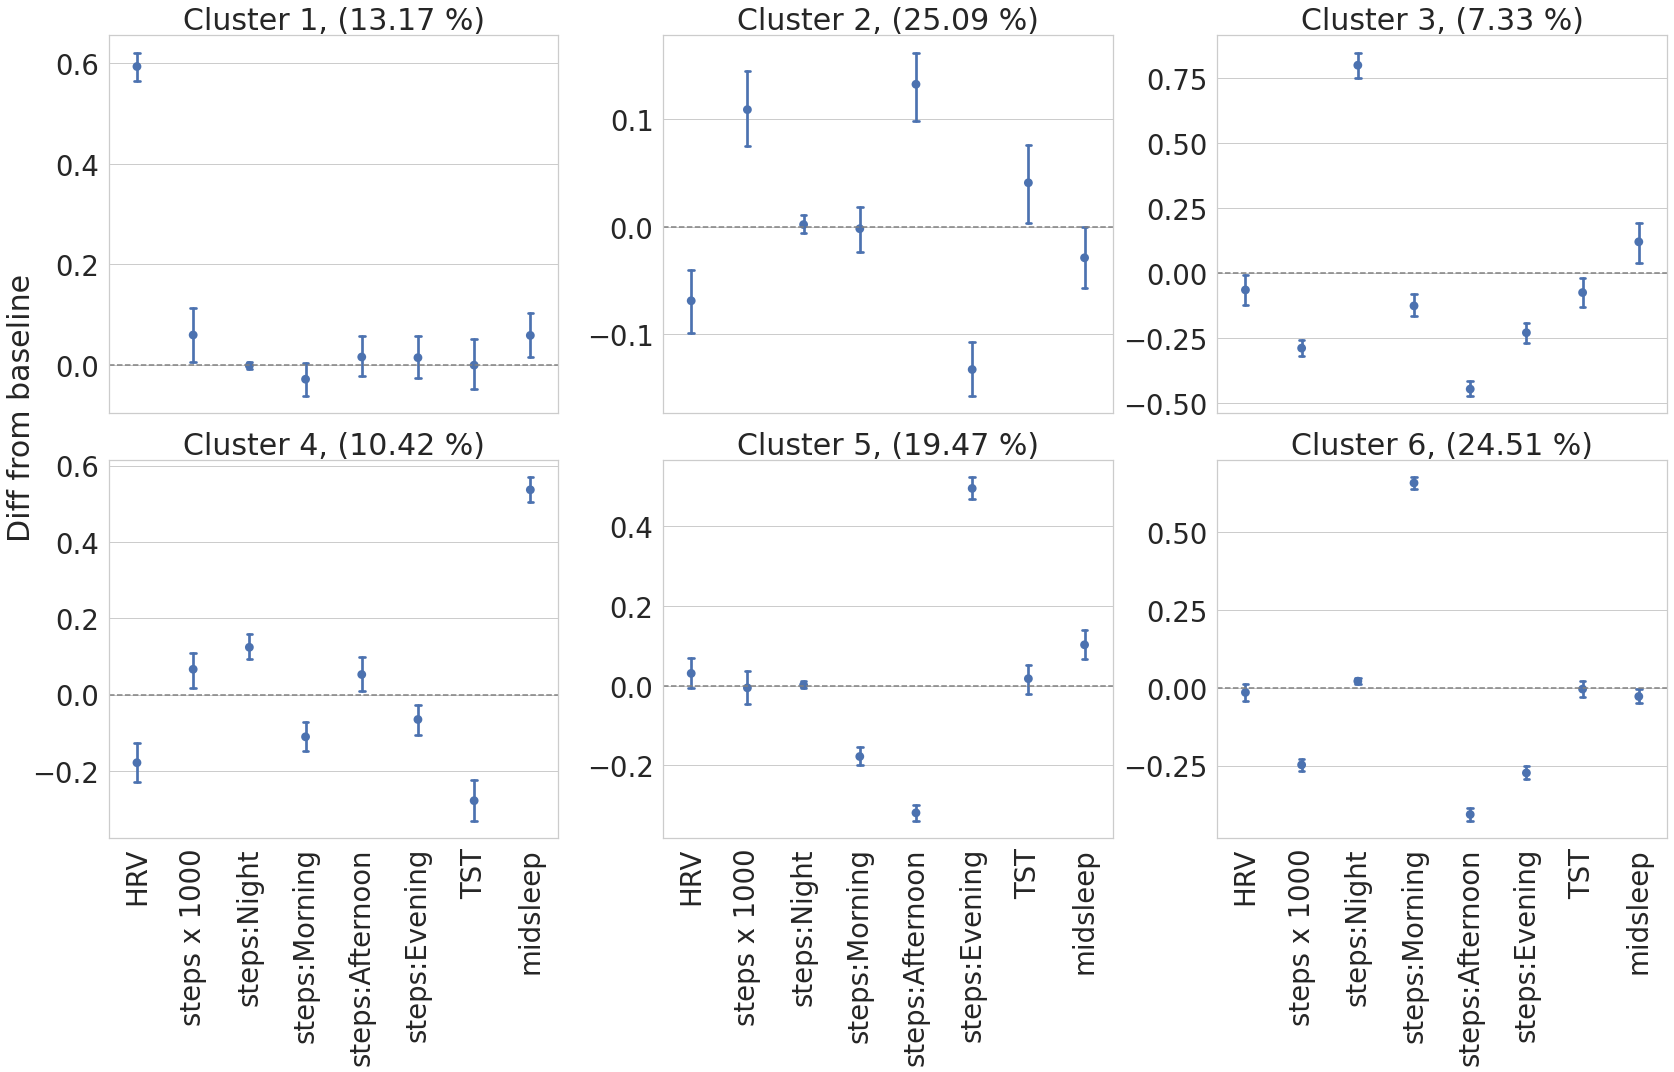

In [9]:
mean_diff.cluster.value_counts()
pivot_mean_diff = pd.melt(mean_diff, id_vars="cluster", value_vars=FEATURES)
pivot_mean_diff["label"] = pivot_mean_diff["variable"].map(
    {
        "heart_rate_variability_avg:norm": "HRV",
        "stepsx1000:total:norm": "steps x 1000",
        "steps:night:norm": "steps:Night",
        "steps:morning:norm": "steps:Morning",
        "steps:afternoon:norm": "steps:Afternoon",
        "steps:evening:norm": "steps:Evening",
        "tst:norm": "TST",
        "midsleep:norm": "midsleep",
    }
)

# Get unique clusters
clusters = pivot_mean_diff["cluster"].unique()

# Set up the matplotlib figure with 2 columns and 3 rows, sharing x-axis
fig, axes = plt.subplots(2, 3, figsize=(23, 15), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate through clusters and create a point plot for each
for i, cluster in enumerate(sorted(clusters)):
    # Filter data for the current cluster
    cluster_data = pivot_mean_diff[pivot_mean_diff["cluster"] == cluster]

    # Create pointplot
    sns.pointplot(
        x="label", y="value", data=cluster_data, capsize=0.1, join=False, ax=axes[i]
    )

    # Add horizontal line at y=0
    axes[i].axhline(0, color="gray", linestyle="--")

    # Set the title to the current cluster
    axes[i].set_title(
        f"Cluster {cluster}, ({np.round(len(cluster_data) / len(pivot_mean_diff) * 100, 2)} %)"
    )

    # Remove the y-axis label
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Improve readability for x-axis labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha="center")

# Set a common x-axis label
fig.text(0.0, 0.5, "Diff from baseline", ha="center", rotation=90, size=30)

# Hide any unused subplots if the number of clusters is less than the number of subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")


plt.tight_layout()
fig.savefig("cluster_outliers.png", dpi=300, bbox_inches="tight")
plt.show()

# MOMO

<div class="alert alert-block alert-info">
<h2> Clustering of outliers </h2>
</div>

In [ ]:
MOMO_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/momo/similarity_matrix/"
INTERIM_PATH = "/m/cs/work/luongn1/digirhythm/data/interim/momo/"
PROCESSED_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/momo/"

study = "momo"
with open(f"../config/features.txt") as f:
    features = json.load(f)

freq = "4epochs"
FEATURES = features[study][freq]

similarity_baseline_si = pd.read_csv(
    MOMO_PATH + f"si/similarity_baseline_{freq}.csv", index_col=0
)

similarity_baseline_si.index = similarity_baseline_si.index.astype("str")

# All behaviour
behaviour_df = pd.read_csv(PROCESSED_PATH + f"vector_{study}_{freq}.csv", index_col=0)

# Baseline behaviour
baseline_df = pd.read_csv(
    INTERIM_PATH + f"all_participants/{freq}_si_baseline.csv", index_col=0
)
behaviour_df

In [ ]:
# Convert to vector of difference from the means

mean_diff = pd.DataFrame()

for uid in similarity_baseline_si.index.unique():
    s_si = similarity_baseline_si.loc[uid].dropna()
    outliers_indices = outliers(s_si)
    outliers_behav = (
        behaviour_df[behaviour_df.user == uid].reset_index().iloc[outliers_indices]
    )
    sample_baseline = baseline_df[baseline_df.index == uid]

    diff_df = outliers_behav[FEATURES] - sample_baseline[FEATURES].values

    group = behaviour_df[behaviour_df.user == uid].group.unique()[0]
    diff_df["user"] = uid
    diff_df["group"] = group
    mean_diff = pd.concat([mean_diff, diff_df])

mean_diff.dropna(inplace=True)
mean_diff.user.unique()

In [ ]:
from sklearn.metrics import silhouette_score

# Determine optimal cluster number with elbow method
wcss = []

silhouette_scores = []
for i in range(2, 11):
    model = KMeans(
        n_clusters=i,
        init="k-means++",  # Initialization method for kmeans
        max_iter=300,  # Maximum number of iterations
        n_init=10,  # Choose how often algorithm will run with different centroid
        random_state=0,
    )  # Choose random state for reproducibility
    labels = model.fit_predict(mean_diff[FEATURES])

    # Silhouette Index
    silhouette_avg = silhouette_score(mean_diff[FEATURES], labels)
    silhouette_scores.append(silhouette_avg)

# Determine optimal cluster number using maximum Silhouette score and maximum Dunn index
optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2
print("Optimal num cluster: ", optimal_clusters_silhouette)

In [ ]:
kmeans = KMeans(
    n_clusters=optimal_clusters_silhouette,  # Set amount of clusters
    init="k-means++",  # Initialization method for kmeans
    max_iter=300,  # Maximum number of iterations
    n_init=10,  # Choose how often algorithm will run with different centroid
    random_state=seed,
)  # Choose random state for reproducibility

pred_y = kmeans.fit_predict(mean_diff[FEATURES])

mean_diff["cluster"] = kmeans.labels_ + 1
mean_diff.groupby("cluster").mean()

# Denote

# Daily clusters
# 0: Night-active individuals with less day activity and later sleep midpoint.
# 1: Morning-active individuals with earlier sleep times.
# 2: Afternoon-active individuals with higher overall activity and variability.
# 3:Evening-active individuals with increased HRV

# Weekly clusters - Pattern
# 0:
# 1: Significantly reduce steps count, increased hrv

In [ ]:
mean_diff.cluster.value_counts()
pivot_mean_diff = pd.melt(mean_diff, id_vars="cluster", value_vars=FEATURES)
pivot_mean_diff["label"] = pivot_mean_diff["variable"]

# Get unique clusters
clusters = pivot_mean_diff["cluster"].unique()

# Set up the matplotlib figure with 2 columns and 3 rows, sharing x-axis
fig, axes = plt.subplots(2, 1, figsize=(21, 12), sharex=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate through clusters and create a point plot for each
for i, cluster in enumerate(clusters):
    # Filter data for the current cluster
    cluster_data = pivot_mean_diff[pivot_mean_diff["cluster"] == cluster]

    # Create pointplot
    sns.pointplot(
        x="variable", y="value", data=cluster_data, capsize=0.1, join=False, ax=axes[i]
    )

    # Add horizontal line at y=0
    axes[i].axhline(0, color="gray", linestyle="--")

    # Set the title to the current cluster
    axes[i].set_title(
        f"Cluster {cluster}, ({np.round(len(cluster_data) / len(pivot_mean_diff) * 100, 2)} %)"
    )

    # Remove the y-axis label
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Improve readability for x-axis labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

# Set a common x-axis label
fig.text(0.0, 0.5, "Diff from baseline", ha="center", rotation=90, size=30)

# Hide any unused subplots if the number of clusters is less than the number of subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")


plt.tight_layout()
fig.savefig("cluster_outliers.png", dpi=300, bbox_inches="tight")
plt.show()